# Análisis predictivo del Alzheimer
Este proyecto tiene como objetivo desarrollar un modelo de aprendizaje autimático capaz de predecir la probabilidad de que un paciente padezca alzheimer, basandose en diversas características

**Objetivo :** 

**¿Porque es relevante este estudio ?**

**Enfoque:**

In [60]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder



## 1. Obtención y exploración de Datos 

In [61]:
ruta = "Data/alzheimers_prediction_dataset.csv"
df = pd.read_csv(ruta,encoding='utf-8', sep=",")
df.head()

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [62]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [63]:
df.isnull().sum()

Country                                 0
Age                                     0
Gender                                  0
Education Level                         0
BMI                                     0
Physical Activity Level                 0
Smoking Status                          0
Alcohol Consumption                     0
Diabetes                                0
Hypertension                            0
Cholesterol Level                       0
Family History of Alzheimer’s           0
Cognitive Test Score                    0
Depression Level                        0
Sleep Quality                           0
Dietary Habits                          0
Air Pollution Exposure                  0
Employment Status                       0
Marital Status                          0
Genetic Risk Factor (APOE-ε4 allele)    0
Social Engagement Level                 0
Income Level                            0
Stress Levels                           0
Urban vs Rural Living             

In [64]:
df.describe()

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


In [65]:
print(df['Alzheimer’s Diagnosis'].value_counts())


Alzheimer’s Diagnosis
No     43570
Yes    30713
Name: count, dtype: int64


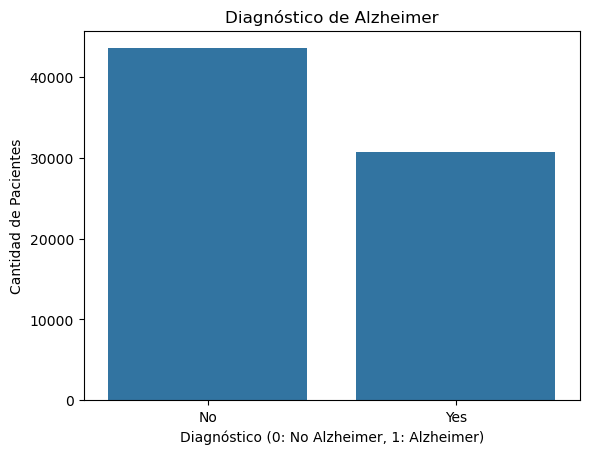

In [66]:
sns.countplot(x=df['Alzheimer’s Diagnosis'])
plt.title('Diagnóstico de Alzheimer')
plt.xlabel('Diagnóstico (0: No Alzheimer, 1: Alzheimer)')
plt.ylabel('Cantidad de Pacientes')
plt.show()

## 2. Limpieza y preprocesamiento
Nuestro dataset tiene tanto variables categóricas como variables numericas, debido a esto es necesario aplicar un preprocesamiento de la data

### 2.1 Conversión de variables categóricas

En este paso vamos a convertir esta variables categoricas a valores numerico que pueda entender la computadora. 

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

In [68]:

print(df.columns)

""" print("Country\n",df['Country'].unique())
print("\nEducation Level\n",df['Education Level'].unique())
print("\nPhysical Activity Level\n", df['Physical Activity Level'].unique())
print("\nSmoking Status\n", df['Smoking Status'].unique())
print("\nAlcohol Consumption\n", df['Alcohol Consumption'].unique())
print("\nDiabetes\n", df['Diabetes'].unique())
print("\nHypertension\n", df['Hypertension'].unique())
print("\nCholesterol Level\n", df['Cholesterol Level'].unique())
print("\nFamily History of Alzheimer’s\n", df['Family History of Alzheimer’s'].unique())
print("\nDepression Level\n", df['Depression Level'].unique())
print("\nSleep Quality\n", df['Sleep Quality'].unique())
print("\nDietary Habits\n", df['Dietary Habits'].unique())
print("\nAir Pollution Exposure\n", df['Air Pollution Exposure'].unique())
print("\nEmployment Status\n", df['Employment Status'].unique())
print("\nMarital Status\n", df['Marital Status'].unique())
print("\nGenetic Risk Factor (APOE-ε4 allele)\n", df['Genetic Risk Factor (APOE-ε4 allele)'].unique())
print("\nSocial Engagement Level\n", df['Social Engagement Level'].unique())
print("\nIncome Level\n", df['Income Level'].unique())
print("\nStress Levels\n", df['Stress Levels'].unique())
print("\nUrban vs Rural Living\n", df['Urban vs Rural Living'].unique())
 """

Index(['Country', 'Age', 'Gender', 'Education Level', 'BMI',
       'Physical Activity Level', 'Smoking Status', 'Alcohol Consumption',
       'Diabetes', 'Hypertension', 'Cholesterol Level',
       'Family History of Alzheimer’s', 'Cognitive Test Score',
       'Depression Level', 'Sleep Quality', 'Dietary Habits',
       'Air Pollution Exposure', 'Employment Status', 'Marital Status',
       'Genetic Risk Factor (APOE-ε4 allele)', 'Social Engagement Level',
       'Income Level', 'Stress Levels', 'Urban vs Rural Living',
       'Alzheimer’s Diagnosis'],
      dtype='object')


' print("Country\n",df[\'Country\'].unique())\nprint("\nEducation Level\n",df[\'Education Level\'].unique())\nprint("\nPhysical Activity Level\n", df[\'Physical Activity Level\'].unique())\nprint("\nSmoking Status\n", df[\'Smoking Status\'].unique())\nprint("\nAlcohol Consumption\n", df[\'Alcohol Consumption\'].unique())\nprint("\nDiabetes\n", df[\'Diabetes\'].unique())\nprint("\nHypertension\n", df[\'Hypertension\'].unique())\nprint("\nCholesterol Level\n", df[\'Cholesterol Level\'].unique())\nprint("\nFamily History of Alzheimer’s\n", df[\'Family History of Alzheimer’s\'].unique())\nprint("\nDepression Level\n", df[\'Depression Level\'].unique())\nprint("\nSleep Quality\n", df[\'Sleep Quality\'].unique())\nprint("\nDietary Habits\n", df[\'Dietary Habits\'].unique())\nprint("\nAir Pollution Exposure\n", df[\'Air Pollution Exposure\'].unique())\nprint("\nEmployment Status\n", df[\'Employment Status\'].unique())\nprint("\nMarital Status\n", df[\'Marital Status\'].unique())\nprint("\nGen

In [69]:
#Variables categóricas Nominales (Sin orden específico)
#One-Hot Encoding: Para variables con pocas categorías
# pip install category_encoders

cols=['Gender','Diabetes','Hypertension','Employment Status','Marital Status','Urban vs Rural Living']
df = pd.get_dummies(df, columns=cols, drop_first=True)


# Variables categiricas Ordinales (Orden específico)
df['Physical Activity Level'] = df['Physical Activity Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Smoking Status'] = df['Smoking Status'].map({'Never': 0, 'Former': 1, 'Current': 2})
df['Alcohol Consumption'] = df['Alcohol Consumption'].map({'Never': 0, 'Occasionally': 1, 'Regularly': 2})
df['Cholesterol Level'] = df['Cholesterol Level'].map({'Normal': 0, 'High': 1})
df['Family History of Alzheimer’s'] = df['Family History of Alzheimer’s'].map({'No': 0, 'Yes': 1})
df['Genetic Risk Factor (APOE-ε4 allele)'] = df['Genetic Risk Factor (APOE-ε4 allele)'].map({'No': 0, 'Yes': 1})
df['Depression Level'] = df['Depression Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Sleep Quality'] = df['Sleep Quality'].map({'Poor': 0, 'Average': 1, 'Good': 2})
df['Dietary Habits'] = df['Dietary Habits'].map({'Unhealthy': 0, 'Average': 1, 'Healthy': 2})
df['Air Pollution Exposure'] = df['Air Pollution Exposure'].map({ 'Low':0 ,'Medium':1,'High':2})
df['Social Engagement Level'] = df['Social Engagement Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Stress Levels'] = df['Stress Levels'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Income Level'] = df['Income Level'].map({'Low': 0, 'Medium': 1, 'High': 2})


# Aplicar Target Encoding a 'Country' 
df['Alzheimer’s Diagnosis'] = df['Alzheimer’s Diagnosis'].map({'No': 0, 'Yes': 1}) #¡¡¡¡Target de la data!!!!
target_enc = TargetEncoder()
df['Country'] = target_enc.fit_transform(df['Country'],df['Alzheimer’s Diagnosis'])

df.head()

,Country,Age,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,...,Stress Levels,Alzheimer’s Diagnosis,Gender_Male,Diabetes_Yes,Hypertension_Yes,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed,Urban vs Rural Living_Urban
0,0.399946,90,1,33.0,1,0,1,0,0,90,...,2,0,True,False,False,True,False,True,False,True
1,0.402037,72,7,29.9,1,1,0,0,0,65,...,2,0,True,False,False,False,True,False,True,True
2,0.495213,86,19,22.9,2,2,1,0,0,43,...,2,0,False,False,True,False,False,True,False,False
3,0.386414,53,17,31.2,0,0,2,0,0,81,...,0,0,True,True,False,True,False,True,False,False
4,0.342098,58,3,30.0,2,1,0,0,0,49,...,2,0,False,True,False,False,False,False,False,False


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  float64
 1   Age                                   74283 non-null  int64  
 2   Education Level                       74283 non-null  int64  
 3   BMI                                   74283 non-null  float64
 4   Physical Activity Level               74283 non-null  int64  
 5   Smoking Status                        74283 non-null  int64  
 6   Alcohol Consumption                   74283 non-null  int64  
 7   Cholesterol Level                     74283 non-null  int64  
 8   Family History of Alzheimer’s         74283 non-null  int64  
 9   Cognitive Test Score                  74283 non-null  int64  
 10  Depression Level                      74283 non-null  int64  
 11  Sleep Quality  

### 2.2. Normalización de variables numéricas

In [71]:
""" 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()  # O usar MinMaxScaler()
df[['Age', 'BMI', 'Income Level']] = scaler.fit_transform(df[['Age', 'BMI', 'Income Level']])
 """

" \nfrom sklearn.preprocessing import StandardScaler, MinMaxScaler\n\nscaler = StandardScaler()  # O usar MinMaxScaler()\ndf[['Age', 'BMI', 'Income Level']] = scaler.fit_transform(df[['Age', 'BMI', 'Income Level']])\n "

## 3. Análisis Exploratorio

### 3.1. Visualización de correlaciones

## 4. Entrenamiento del Modelo

## 5. Optinización y comparación de modelos 